In [ ]:
import sys
#First argument for the number of runs, second for the initial run
j=int(sys.argv[2])
n=int(sys.argv[1])
f=open("tesr.txt","a")


In [1]:
#loading yeast groundtruth 0 data
yeast=open("yeast_residual_data_full_1000_gt_2.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]


In [2]:
#loading yeast groundtruth 1 data
yeast=open("yeast_residual_data_full_1000_gt_1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,1000):
  line=yeast.readline()
  #line=line[1:-2] #remove double quotes 
  #param = [j for j in line.split()]
  #print(param)
  #chrname.append(param[1])
  #g1.append(param[2])
  #g2.append(param[3])
  line=yeast.readline()
  l = [j for j in line.split()]
  L.append([int(i) for i in l])
  line=yeast.readline()
  a = [j for j in line.split()]
  A.append([float(i) for i in a])
  line=yeast.readline()
  b = [j for j in line.split()]
  B.append([float(i) for i in b])
dataset_1 = [i for i in zip(L,A,B)]

#reshapefunction



In [3]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2

2022-03-15 20:58:45.170546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 20:58:45.170582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
#defining the class MDN
class MDN_module(tf.keras.Model):

    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [6]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [5]:
def compute_loss(P,Q):
  """ Compute the loss for the given pair
  """
  opt = tf.optimizers.Adam(1e-2)
  mdn_PQ = MDN_module()
  mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
  mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=50,  batch_size=64,verbose=0)
  return eval_mdn_model(P,Q,mdn_PQ)


In [8]:
def shuffleBtimes(P,Q,B):
  """ Shuffle Q B times and compute the loss 
  """
  loss=[]
  for i in range(0,B):
      loss.append(compute_loss(P,np.random.permutation(Q)))
  return loss


In [1]:
def LinearLABData():
  """ Generate the linear data 
  """
  L = np.random.binomial(1,0.5,1000)  
  beta0 = np.ones(1000)-0.4
  #beta1 = 0.5
  beta1=3
  beta2= 0.3
  beta3=0.8
  eps0 = np.random.standard_normal(1000)
  eps1 = np.random.standard_normal(1000)
  A = beta0 + beta1*L + eps0
  B = beta2+ beta3*A# + eps1 
  plt.scatter(A,B)
  plt.title("A vs B")
  plt.xlabel("A")
  plt.ylabel("B")
  return [L,A,B]

In [4]:
def residual(P,Q):
  """ Calculate the residual 
  """
  opt = tf.optimizers.Adam(1e-2)
  mdn_PQ = MDN_module()
  mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
  mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=50,  batch_size=64,verbose=0)
  y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
  #model=sm.OLS(Q,P).fit() 
  #print(model.resid)
  #return model.resid #Linear residual
  #non linear residual
 # print(y_pred)
  #print(Q)
 #print(Q-y_pred[:,1])
  return (Q-y_pred[:,1])
  

In [6]:
#yeast_name=""
def yeast_data(i,ind):
    '''
    Function to return the trios with the gndtruth 0/1 based on i and the number based on ind 
    '''
    global yeast_name
    yeast_name="yeast_"+str(i)+"_"+str(ind)
    ds = eval("dataset_"+str(i)+"["+str(ind)+"]")
    L_dist = np.array(ds[0]) #np.array(ds[0])
    A_dist = np.array(ds[1])
    B_dist = np.array(ds[2])
    plt.scatter(A_dist,B_dist)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L_dist,A_dist,B_dist]

In [57]:
def calculate_pvalue(original,loss_list,test):
    '''
    calculate the p value 
    '''
    if(test==1 or test==2):
        return sum(i < original for i in loss_list)/len(loss_list)
    
    return sum(i > original for i in loss_list)/len(loss_list)
    

In [12]:
def stratify_B_n_times(L,A,B,n):
    '''
    Stratify B wrt to L
    '''
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
      
      B_dist_temp=np.zeros(len(B))
      mod_indices_1=random.sample(indices_1,len(indices_1))
      for i in range(len(indices_1)):
        B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

      mod_indices_0=random.sample(indices_0,len(indices_0))
      for i in range(len(indices_0)):
        B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
      #print(B_dist_temp)
      loss.append(compute_loss(L,residual(A,B_dist_temp)))

    return loss 




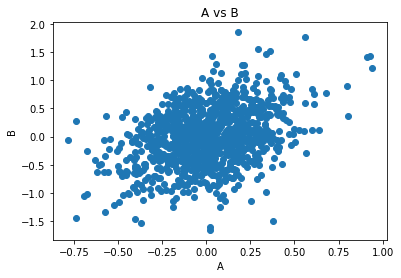

In [109]:
random.seed(24)


In [7]:
for i in range(j,j+n): 
    print(sys.argv[1]," ",sys.argv[2])


    shuffles=100
    #L,A,B=LinearLABData()
    L,A,B=yeast_data(1,i)

    A_shuffle=np.copy(A)
    B_shuffle=np.copy(B)
    #print("Original",B_shuffle)
    loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles)
    loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles)
    loss_list_Bresidual=stratify_B_n_times(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
    true_LA=compute_loss(L,A)
    true_LB=compute_loss(L,B)
    #print("Next",B_shuffle)
    true_LBresidual=compute_loss(L,residual(A,B_shuffle))
    LA_p=calculate_pvalue(true_LA,loss_list_LA,1)
    LB_p=calculate_pvalue(true_LB,loss_list_LB,2)
    AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual,3)
    f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #true_LindB_A=compute_loss(L,B_resid)


NameError: name 'j' is not defined

In [ ]:
f.close()